In [3]:
import pandas as pd
from OpenDutchWordnet import Wn_grid_parser
import argparse
import re
import nltk
import xgboost
import re
import numpy as np
import stanza
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import scale
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import json
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [6]:
def clean_text(text):
    if not isinstance(text, str):
        print(text)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    no_emoji = emoji_pattern.sub(r'', text)
    
    # Remove urls
    no_urls = re.sub(r"http\S+", "", no_emoji)
    
    # Remove punctuation, numbers and symbols
    no_punct_symbols_nrs = re.sub(r'[^A-Za-z\s]+', '', no_urls)
    
    # Remove trailing white space
    no_trailing_ws = " ".join(no_punct_symbols_nrs.split())
    
    # Lowercase
    text_clean = no_trailing_ws.lower()
    return text_clean

def lemmatize(nlp, text):
    doc = nlp(text)
    lemmatized = [word.lemma for sent in doc.sentences for word in sent.words]
    return lemmatized

In [7]:
def process_data(nlp, df_train, df_test):
    # Clean text
    df_train['clean_text'] = df_train['text'].apply(lambda x: clean_text(x))

    # Remove empty values
    df_train = df_train[df_train['clean_text'] != '']
    
    # Lemmatize 
    df_train['lemmatized_clean_text'] = df_train['clean_text'].apply(lambda x: lemmatize(nlp, x))    

    df_test['clean_text'] = df_test['message'].apply(lambda x: clean_text(x))
    df_test = df_test[df_test['clean_text'] != '']        
    df_test['lemmatized_clean_text'] = df_test['clean_text'].apply(lambda x: lemmatize(nlp, x))  
    
    # Binary labels
    df_test['labels'].replace({"y": 1, "n": 0}, inplace=True)
    return df_train, df_test

In [8]:
def get_hypernyms (instance, synset_id, hypers):
    synset = instance.synsets_find_synset(synset_id)
    if synset:
        hypernyms = synset.get_relations("has_hyperonym")
        if hypernyms:
            for h in hypernyms:
                if (h):
                    if not h.get_target() in hypers:
                        hypers.append(h.get_target())
                        get_hypernyms(instance, h.get_target(), hypers)


def get_hypernyms_lemmas():
    # ['ontmoeten',
    #  'voelen',
    #  'meemaken',
    #  'ondervinden',
    #  'ondergaan',
    #  'gevoelen',
    #  'zich omkleden',
    #  'ervaren',
    #  'gewaarworden',
    #  'kenteren',
    #  'doorleven',
    #  'veranderen',
    #  'keren',
    #  'beleven']
    instance = Wn_grid_parser(path_wn_grid_lmf='odwn_orbn_gwg-LMF_1.3.xml.gz')
    le_el = instance.les_find_le("voelen-v-2")
    synset_el = instance.synsets_find_synset(le_el.get_synset_id())
    hypers = []
    get_hypernyms(instance, synset_el.get_id(), hypers)
    new_hypers = []

    lemmas = []
    for hyper in hypers:
        new_hypers.append(hyper)
        for le in instance.les_all_les_of_one_synset(hyper):
            lemmas.append(le.get_lemma())  

    for hyper in new_hypers:
        hypers = []
        get_hypernyms(instance, hyper, hypers)
        new_hypers = []
        for hyper in hypers:
            new_hypers.append(hyper)
            for le in instance.les_all_les_of_one_synset(hyper):
                lemmas.append(le.get_lemma())
                
    return list(set(lemmas+['voelen']))

In [9]:
def check_match(match, clean_text):
    if re.search(match, clean_text):
        return 1
    else: 
        return 0
    
def WN_lemma_replace(WN_synsets, clean_text, lemmatized_clean_text):
    clean_text_tokenized = clean_text.split(" ")
    for wn in WN_synsets:
        if wn in lemmatized_clean_text:
            for i, word in enumerate(lemmatized_clean_text):
                if wn == word:
                    clean_text_tokenized[i] = clean_text_tokenized[i].replace(clean_text_tokenized[i], wn)
    clean_text = " ".join(clean_text_tokenized)
    return clean_text

def remove_matches(match, clean_text, filters):
    regex_matches = re.findall(match, clean_text)
    if filters == [2]:
        removes = regex_matches
    else:
        removes = list(set((sum(regex_matches, ()))))
    return ' '.join([word for word in clean_text.split() if word not in removes])

def heuristics_labelling(df_train, df_test, WN_synsets, filters, remove):
    
    df_train['clean_text_lemma'] = df_train['clean_text']
    df_test['clean_text_lemma'] = df_test['clean_text']
    
    matches = []
    if 0 in filters:
        matches.append("((heb|heeft|hebben) [a-z]* (gehad))")
    if 1 in filters:
        matches.append("((mijn|mn|me|m n|mij|men) (vader|moeder|ouder|schoonvader|schoonmoeder|kind|zoon|dochter|man|vrouw|broer|zus|neef|nicht|tante|oom))")
    if 2 in filters:
        df_train['clean_text_lemma'] = df_train[['clean_text', 'lemmatized_clean_text']].apply(lambda x: WN_lemma_replace(WN_synsets, x.clean_text, x.lemmatized_clean_text), axis=1)
        df_test['clean_text_lemma'] = df_test[['clean_text', 'lemmatized_clean_text']].apply(lambda x: WN_lemma_replace(WN_synsets, x.clean_text, x.lemmatized_clean_text), axis=1)
                
        matches.append('('+'|'.join(WN_synsets)+')')

    match = '|'.join(matches)
    df_train['labels'] = df_train['clean_text_lemma'].apply(lambda x: check_match(match, x))
    df_test['predicted'] = df_test['clean_text_lemma'].apply(lambda x: check_match(match, x))
      
    if remove == True:
        df_train['clean_text_removals'] = df_train['clean_text_lemma'].apply(lambda x: remove_matches(match, x, filters))
        df_test['clean_text_removals'] = df_test['clean_text_lemma'].apply(lambda x: remove_matches(match, x, filters))

In [10]:
def resample_data(df_train, df_train_labels):
    over= RandomOverSampler(sampling_strategy=1, random_state=42)
    df_train_sampled, df_train_sampled_labels = over.fit_resample(df_train, df_train_labels)
    return df_train_sampled


In [11]:
def create_train_test(df_train, df_test, vectorizer, remove):
    vect = vectorizer
    y_train = df_train['labels']
    y_test = df_test['labels']
    if remove == True:
        corpus = df_train['clean_text_removals'].tolist()
        X_train = vect.fit_transform(corpus)
        X_test = vect.transform(df_test['clean_text_removals'])
    else:
        corpus = df_train['clean_text'].tolist()
        X_train = vect.fit_transform(corpus)
        X_test = vect.transform(df_test['clean_text'])
    return X_train, y_train, X_test, y_test

In [12]:
def create_train_test_unlabelled(df_train, df_test, vectorizer, remove):
    vect = vectorizer
    y_train = df_train['labels']
    if remove == True:
        corpus = df_train['clean_text_removals'].tolist()
        X_train = vect.fit_transform(corpus)
        X_test = vect.transform(df_test['clean_text_removals'])
    else:
        corpus = df_train['clean_text'].tolist()
        X_train = vect.fit_transform(corpus)
        X_test = vect.transform(df_test['clean_text'])
    return X_train, y_train, X_test

In [13]:
def create_cm(true_labels, predicted_labels):
    cm = metrics.confusion_matrix(true_labels, predicted_labels)
        
    fig, ax = plot_confusion_matrix(conf_mat=cm,
                                    colorbar=False,
                                    show_absolute=False,
                                    show_normed=True,
                                    class_names=['non-exp','exp'])
    fig.set_size_inches(10, 10.5)

    
def class_feature_importance(X, Y, feature_importances, vect):
    N, M = X.shape
    X = scale(X, with_mean=False)

    out = {}
    for c in set(Y):
        out[c] = dict(
            zip(vect.get_feature_names(), np.mean(X[Y==c, :], axis=0)*feature_importances)
        )

    return out    

def classification_experiments(X_train, y_train, X_test, y_test):
    print("--------------------------------")
    print("Logistic Regression")
    
    clf = LogisticRegression(random_state=42).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("LR: ROC-AUC:", roc_auc_score(y_test, y_pred))
#     create_cm(y_test, y_pred)
    
    print("--------------------------------")
    print("XGBoost Random Forest")
    
    xgbc = XGBClassifier(objective="binary:logistic", random_state=42, eval_metric='logloss')
    xgb = xgbc.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("XGB: ROC-AUC:", roc_auc_score(y_test, y_pred))
#     create_cm(y_test, y_pred)

In [14]:
def full_data_train_test_split(full_df, sub_df, test_df):
    test_ids = test_df['object_id'].tolist()
    sub_ids = sub_df['object_id'].tolist()
    full_df = full_df[~full_df.object_id.isin(test_ids)]
    full_df = full_df[~full_df.object_id.isin(sub_ids)]
    
    # full_df_test is for prediction
    full_df_train_no_sentiment, full_df_test = train_test_split(full_df, test_size=0.42, random_state=42)
    full_df_train = pd.concat([full_df_train_no_sentiment, sub_df]) #sub_df  is around 2 percent
    return full_df_train, full_df_test

In [15]:
def create_predicted(unlabelled_df, unlabelled_X_test, best_model, name):
    predictions = best_model.predict_proba(unlabelled_X_test)
    unlabelled_df['best_model_pred'] = predictions
    unlabelled_df[['text', 'best_model_pred']].to_csv(name+'.tsv', delimiter='\t', index=False)

In [16]:
def create_lemmatized_files():
    df_train = pd.read_csv('fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.csv', sep='\t')
    df_test = pd.read_csv('experience_test/Fb_random_sample_500_annotated_discussed.tsv', sep='\t')
    sub_df = pd.read_csv('high_sent_subjFB_NOS_NU_Telegraaf_NRC_all_endFeb.csv', sep='\t')
    
    df_train = df_train[~df_train['text'].isna()]
    df_test = df_test[~df_test['message'].isna()]
    sub_df = sub_df[~sub_df['text'].isna()]
    
    nlp = stanza.Pipeline(lang='nl', processors='tokenize,pos,lemma')
    df_train_sent, df_test_sent = process_data(nlp, sub_df, df_test)
    print("Finished sentiment")
    df_train, df_test = process_data(nlp, df_train, df_test)
    print("Finished train and test")
 
    df_test_sent.to_csv('lemmatized_test_high_sent_subjFB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')
    df_train_sent.to_csv('lemmatized_train_high_sent_subjFB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')

    df_train.to_csv('lemmatized_train_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t') # no test 
    df_test.to_csv('lemmatized_test_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')
    

In [17]:
def results_models():
    # comment this when not using unlabelled    
#     df_train = pd.read_csv('lemmatized_train_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')
#     sub_df = pd.read_csv('lemmatized_train_high_sent_subjFB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')
#     df_train, df_unlabelled = full_data_train_test_split(df_train, sub_df, df_test)
#     df_train.to_csv('lemmatized_train_no_unlabelled_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t') 
#     df_unlabelled.to_csv('lemmatized_unlabelled_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')

    df_train = pd.read_csv('lemmatized_train_no_unlabelled_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')
    df_test = pd.read_csv('lemmatized_test_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')

    WN_synsets = get_hypernyms_lemmas()
    
    vectorizers = [TfidfVectorizer(), CountVectorizer(binary=True)]
    removes = [False, True]
    filters = [[0], [1], [2], [0, 1], [1, 2], [0, 2], [0, 1, 2]]
    for vect in vectorizers:
        print(vect)
        print('-----------------')
        for remove in removes:
            print(remove)
            print('-----------------')
            for filter_ in filters:
                print(filter_)
                print('-------------------')
                heuristics_labelling(df_train, df_test, WN_synsets, filter_, remove)
                print('DATA STATS: ', df_train['labels'].value_counts())

                df_train_sampled = resample_data(df_train, df_train['labels'])
                X_train, y_train, X_test, y_test = create_train_test(df_train_sampled, df_test, vect, remove)
                print('-------------------')
                print("BASELINE")
                print(classification_report(df_test['labels'], df_test['predicted']))
                classification_experiments(X_train, y_train, X_test, y_test)

In [18]:
def prediction_labelling(df_train, df_test, df_unlabelled_test, WN_synsets):
    # Best XGB 
    heuristics_labelling(df_train, df_unlabelled_test, WN_synsets, [0,1,2], False)
    df_train_sampled = resample_data(df_train, df_train['labels'])
    bin_vect = CountVectorizer(binary=True)
    X_train, y_train, X_test, y_test = create_train_test(df_train_sampled, df_test, bin_vect, False)

    _, _, unlabelled_X_test = create_train_test_unlabelled(df_train_sampled, df_unlabelled_test, bin_vect, False)
    
    predictions = best_xgb.predict_proba(unlabelled_X_test)[:, 1]

    df_unlabelled_test['best_model_pred'] = predictions
    df_unlabelled_test[['text', 'best_model_pred']].to_csv('unlabelled_predictions_by_bestmodel.tsv', sep='\t', index=False)

def best_xgb_results(df_train, df_test, WN_synsets):
    heuristics_labelling(df_train, df_test, WN_synsets, [0,1,2], False)
    df_train_sampled = resample_data(df_train, df_train['labels'])
    bin_vect = CountVectorizer(binary=True)
    X_train, y_train, X_test, y_test = create_train_test(df_train_sampled, df_test, bin_vect, False)
    best_xgb = XGBClassifier(objective="binary:logistic", random_state=42, eval_metric='logloss').fit(X_train, y_train)  
    y_pred = best_xgb.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    importance = best_xgb.feature_importances_

    result = class_feature_importance(X_test.toarray(), y_pred, importance, bin_vect)

    d = result.get(1)

    sorted_d = sorted(d.items(), key=lambda x: x[1], reverse=True)
    print(sorted_d[:20])
    
    return best_xgb, y_pred, y_test
    
def best_lr_results(df_train, df_test, WN_synsets):
    heuristics_labelling(df_train, df_test, WN_synsets, [0,1], True)
    df_train_sampled = resample_data(df_train, df_train['labels'])
    tfidf = TfidfVectorizer()
    X_train, y_train, X_test, y_test = create_train_test(df_train_sampled, df_test, tfidf, True)
    clf = LogisticRegression(random_state=42).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Logistic Regression")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    importance = clf.coef_[0]

    result = class_feature_importance(X_test.toarray(), y_pred, importance, tfidf)

    d = result.get(1)

    sorted_d = sorted(d.items(), key=lambda x: x[1], reverse=True)

    print(sorted_d[:20])
    
    return clf, y_pred, y_test

In [23]:
def create_sample_dfs():
    bm_df = pd.read_csv('predicted_data/unlabelled_predictions_by_xgb-binary-keepfeat.tsv', sep='\t', header=None)
#     bm_df[:250].to_csv('predicted_data/top-250-unlabelled_predictions_by_xgb-binary-keepfeat.tsv', sep='\t', header=False)

    bm_df_unlabelled = bm_df.fillna('Unlabelled')
    labelled = bm_df_unlabelled[bm_df_unlabelled[3] != 'Unlabelled']
    labelled[[0, 1, 3]].to_csv('predicted_data/workshop_labelled_predictions_by_xgb-binary-keepfeat.csv', sep='\t', header=False)

    bm_df_unlabelled = bm_df[~bm_df[1].isin(labelled.index)]
    above_unlabelled_09 = bm_df_unlabelled[bm_df_unlabelled[1] >= 0.9]
    above_unlabelled_09_sample = above_unlabelled_09.sample(n=250, random_state=50)
    above_unlabelled_09_sample[[0]].to_csv('predicted_data/sample_unlabelledpredictions_over0-9_by_xgb-binary-keepfeat.csv', sep='\t', header=False, index=False)
    
    below_unlabelled_09 = bm_df_unlabelled[bm_df_unlabelled[1] < 0.9]
    below_unlabelled_09 = below_unlabelled_09[below_unlabelled_09[1] >= 0.5]
    below_unlabelled_09_sample = below_unlabelled_09.sample(n=250, random_state=50)
    below_unlabelled_09_sample[[0]].to_csv('predicted_data/sample_unlabelledpredictions_below0-9_by_xgb-binary-keepfeat.csv', sep='\t', header=False, index=False)

    
#     sns.histplot(below_250_unlabelled[1], stat="probability", bins=10, kde=True)
#     below_250_unlabelled['bin'] = pd.cut(below_250[1], 10)
#     print(below_250_unlabelled.bin.value_counts())

#     sample_df = below_250_unlabelled.groupby('bin').sample(n=100, random_state=1)
#     sample_df[[0, 1, 3, 'bin']].to_csv('predicted_data/sample_unlabelled_predictions_by_xgb-binary-keepfeat.tsv', sep='\t', header=False)

In [24]:
create_sample_dfs()

In [31]:
def correct_preds_index(y_test, y_pred):
    return [1 if i == j else 0 for i, j in zip(y_test, y_pred)]

In [32]:
def main():
    df_train = pd.read_csv('lemmatized_train_no_unlabelled_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')
    df_test = pd.read_csv('lemmatized_test_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')
    df_unlabelled_test = pd.read_csv('lemmatized_unlabelled_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')
    WN_synsets = get_hypernyms_lemmas()
    
#     create_lemmatized_files()
#     results_models()
#     prediction_labelling(df_train, df_test, df_unlabelled_test, WN_synsets)

    print("LR")
    lr, y_pred_lr, y_test = best_lr_results(df_train, df_test, WN_synsets)
    lr_correct = incorrect_preds_index(y_test, y_pred_lr)
    
    print("XGB")
    xgb, y_pred_xgb, y_test = best_xgb_results(df_train, df_test, WN_synsets)
    xgb_correct = correct_preds_index(y_test, y_pred_xgb)
    create_sample_dfs()

    print("correct matrix")
    print(confusion_matrix(lr_correct, xgb_correct))
    
    print("prediction matrix")
    print(confusion_matrix(y_pred_lr, y_pred_xgb))
    
    

C:\Users\jmich\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  


LR


C:\Users\jmich\Anaconda3\envs\py37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Regression
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       451
           1       0.48      0.43      0.45        49

    accuracy                           0.90       500
   macro avg       0.71      0.69      0.70       500
weighted avg       0.89      0.90      0.90       500

[[428  23]
 [ 28  21]]


C:\Users\jmich\Anaconda3\envs\py37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('ouders', 17.501223097464504), ('ik', 13.233149680565687), ('en', 10.550908092880437), ('heeft', 10.305351781605214), ('kinderen', 6.112166758242883), ('in', 6.017148975877178), ('is', 5.656248520819799), ('niet', 5.237692165772117), ('toen', 4.544841165156766), ('ook', 4.369744690592672), ('van', 4.203455138804294), ('was', 3.8428262194430327), ('zei', 3.718128332636853), ('haar', 3.6269143242309183), ('vorig', 3.354185663333869), ('gehad', 3.2988254400502233), ('nooit', 3.2777150919286537), ('geen', 3.2769772580204997), ('op', 3.247193079487749), ('april', 3.1308151499412293)]
XGB


C:\Users\jmich\Anaconda3\envs\py37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.95      0.90      0.92       451
           1       0.39      0.59      0.47        49

    accuracy                           0.87       500
   macro avg       0.67      0.74      0.70       500
weighted avg       0.90      0.87      0.88       500

[[405  46]
 [ 20  29]]


C:\Users\jmich\Anaconda3\envs\py37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('mijn', 0.09343914668439769), ('en', 0.041772649309964334), ('het', 0.017842216899065472), ('gehad', 0.015569943010862433), ('die', 0.01281091548509963), ('voelen', 0.012730201814351621), ('de', 0.012662943755638402), ('veranderen', 0.010227982211758687), ('te', 0.008897057075766523), ('we', 0.007197630920630591), ('hem', 0.006540817060631899), ('in', 0.005490817695118779), ('moeder', 0.0053881556941996), ('heb', 0.005128675422537871), ('ik', 0.003370459439539001), ('ook', 0.0032107775940498863), ('kind', 0.0028753391959542504), ('ondergaan', 0.0028723613521754745), ('is', 0.0026667395050990876), ('mn', 0.002632448118747101)]
(0.00617, 0.105]    41907
(0.105, 0.204]       2603
(0.204, 0.302]        818
(0.302, 0.4]          727
(0.4, 0.498]          694
(0.498, 0.596]        600
(0.891, 0.989]        493
(0.596, 0.694]        363
(0.694, 0.793]        186
(0.793, 0.891]        175
Name: bin, dtype: int64
correct matrix
[[ 20  31]
 [ 46 403]]
prediction matrix
[[402  54]
 [ 23  21]]


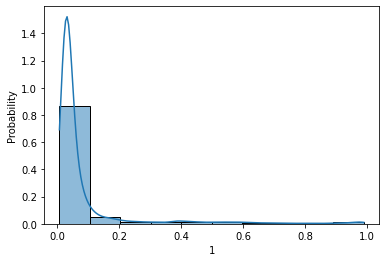

In [33]:
if __name__ == "__main__":
    main()
    